In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

### Load and normalize dataset

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. Convolutional Neural Network



In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #This layer has 3 input channels (e.g., for RGB images), 6 output channels, and a kernel size of 5x5
        self.pool = nn.MaxPool2d(2, 2) #max-pooling layer with a 2x2 window size and a stride of 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #This line creates a fully connected (linear) layer with 16 * 5 * 5 input features (which is the result of flattening the output of the second convolutional layer) and 120 output features.
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #output layer has 10 nodes because there are 10 classes in the dataset.

    def forward(self, x):
        # print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x))) #same pool on 2nd convolution
        # print(x.size())
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        # print(x.size())
        x = F.relu(self.fc2(x))
        # print(x.size())
        x = self.fc3(x)
        # print(x.size())
        return x


net = Net()

### 3. Loss function and optimizer



In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.8)

# optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer3 = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.9)

### 4. Training



In [21]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the loss values
loss_values = []

# Training loop
for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store the loss value in the list
        running_loss += loss.item()

        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            loss_values.append(running_loss / 2000)  # Append the average loss to the list
            running_loss = 0.0


print('Finished Training')


[1,  2000] loss: 2.306
[1,  4000] loss: 2.302
[1,  6000] loss: 2.300
[2,  2000] loss: 2.296
[2,  4000] loss: 2.291
[2,  6000] loss: 2.284
[3,  2000] loss: 2.263
[3,  4000] loss: 2.226
[3,  6000] loss: 2.173
[4,  2000] loss: 2.134
[4,  4000] loss: 2.111
[4,  6000] loss: 2.091
[5,  2000] loss: 2.068
[5,  4000] loss: 2.049
[5,  6000] loss: 2.015
[6,  2000] loss: 1.971
[6,  4000] loss: 1.941
[6,  6000] loss: 1.917
[7,  2000] loss: 1.892
[7,  4000] loss: 1.868
[7,  6000] loss: 1.841
[8,  2000] loss: 1.813
[8,  4000] loss: 1.795
[8,  6000] loss: 1.761
Finished Training


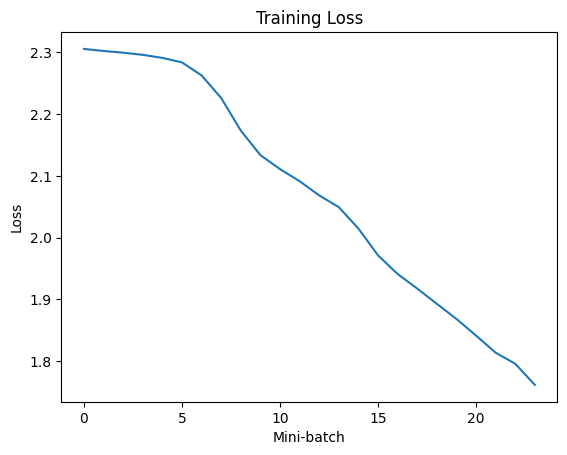

In [22]:
# Plot the loss values
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Mini-batch')
plt.ylabel('Loss')
plt.show()

In [19]:
plt.savefig("exp-1.png")

<Figure size 640x480 with 0 Axes>

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [8]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy of the network on the test data: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy of the network on the test data: 37.17%
Precision: 0.36
Recall: 0.37
F1 Score: 0.35
